# Mini project

## Goal of this project
* To get COVID-19 result from home(why? - to avoid spreading COVID-19)

## Plan to attack this project

The result is given based on these three phases
* phase-1: model(NLP) for written text(for example, how the person feel in his/her body) input.
* phase-2: model(ANN) for input data input like: sex, age, went_icu and temperature
* phase-3: model(CNN) for x-ray images

## Materials needed to fulfill the process after this project is done
* A x-ray image (here we assume that there are mobiles which takes x-ray image)
* Internet access

# Importing Libraries and Data

In [13]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
import texthero as hero
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pickle

import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing import image
from keras.models import load_model
#import sweetviz as sv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<h1><center><u>PHASE-1</u></center></h1>

# Importing and cleaning data

In [120]:
data = pd.read_csv("/content/gdrive/MyDrive/DATA/metadata.csv")

In [121]:
data.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [138]:
#data_report = sv.analyze(data)
#data_report.show_notebook(layout="vertical", w=880, h=700, scale=0.8)


In [13]:
data = data[["clinical_notes", "date", "RT_PCR_positive"]]

In [14]:
data.head()

,clinical_notes,date,RT_PCR_positive
0,"On January 22, 2020, a 65-year-old man with a ...","January 22, 2020",Y
1,"On January 22, 2020, a 65-year-old man with a ...","January 25, 2020",Y
2,"On January 22, 2020, a 65-year-old man with a ...","January 27, 2020",Y
3,"On January 22, 2020, a 65-year-old man with a ...","January 28, 2020",Y
4,diffuse infiltrates in the bilateral lower lungs,"January 25, 2020",Y


In [15]:
# the goal here to exclude the year before 2019
# and take away the clinical_notes without date to avoid misleading
for i in range(950):
  if isinstance(data["date"][i], str) and (data["date"][i].endswith("19") or data["date"][i].endswith("20") or data["date"][i].endswith("21")):
    pass
  else:
    data = data.drop(i)

In [16]:
# now we drop the date
data  = data[["clinical_notes", "RT_PCR_positive"]]

In [17]:
data.head()

,clinical_notes,RT_PCR_positive
0,"On January 22, 2020, a 65-year-old man with a ...",Y
1,"On January 22, 2020, a 65-year-old man with a ...",Y
2,"On January 22, 2020, a 65-year-old man with a ...",Y
3,"On January 22, 2020, a 65-year-old man with a ...",Y
4,diffuse infiltrates in the bilateral lower lungs,Y


In [18]:
# drop nan in both columns
data = data.dropna(subset=["clinical_notes"])
data = data.dropna(subset=["RT_PCR_positive"])

In [ ]:
#data.sort_values("clinical_notes", inplace = True)
data.drop_duplicates(subset ="clinical_notes", keep = False, inplace = True)

In [31]:

def removeMeaninglesWords(x_data):
  """
  Parm: a columns from data-set to be cleaned(has series type)
  Returns: list(str)
  """
  cleaned_clinical_note = []
  # inds characters not in the range: a-zA-Z and whitespace and '
  alphabetic = re.compile(r"[^a-zA-Z\s]")
  # finds single quotes not within a word
  singlequote = re.compile(r"((\W)(?:\B|$)|(?:^|\B)(\W))")
  stop_words = stopwords.words('english')
  for text in x_data:
    new_words = []
    text = unidecode(text) # example: ã'bç becomes abc
    text = re.sub(alphabetic, " ", text) #example: 2"3can't"/ becomes can't
    text = re.sub(singlequote, " ", text) #''' shouldn't '''''' becomes shouldn't
    words = text.lower().split()
    for word in words:
      if (not (word in stop_words) and (word.strip()) and len(word)>1):
        new_words.append(word)
      else:
        continue
    cleaned_clinical_note.append(" ".join(new_words))
  return cleaned_clinical_note


In [32]:
cleaned_data =  removeMeaninglesWords(data["clinical_notes"])

In [34]:
# to show us the difference b/n the orginal and the new on 
def countDifference():
  sum_orginal = 0
  sum_cleaned = 0
  for i in range(len(data)):
      sum_orginal += len(data["clinical_notes"].iloc[i].split(" "))
      sum_cleaned += len(cleaned_data[i].split(" "))
  print("*"*100)
  print("Original words: ", sum_orginal)
  print("Without stopwords & alnum: ", sum_cleaned)
  print("Difference : ", sum_orginal - sum_cleaned)
countDifference()

****************************************************************************************************
Original words:  27712
Without stopwords & alnum:  17889
Difference :  9823


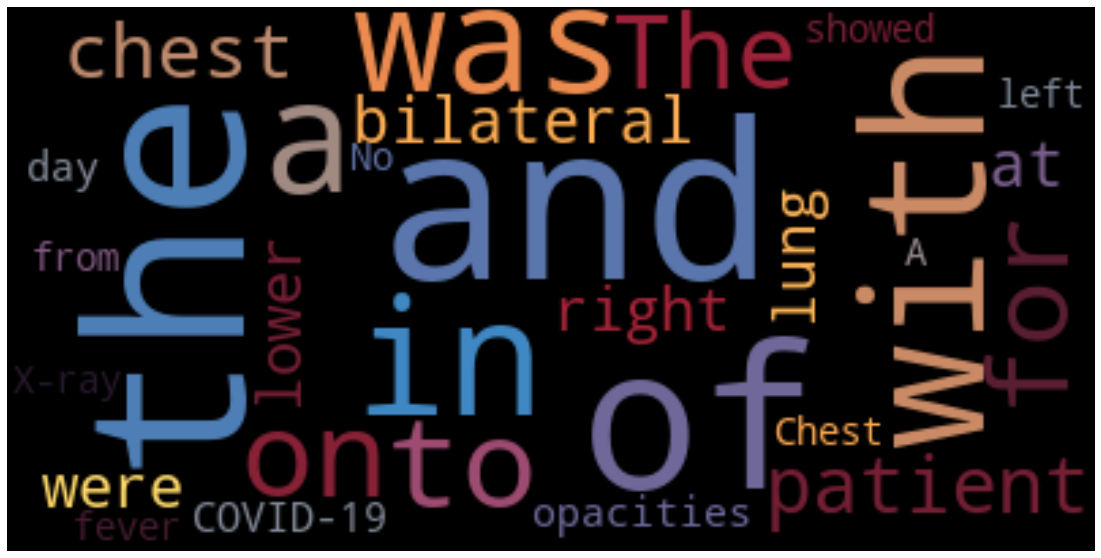

In [37]:
# visualizing uncleaned data(where max appearance is 30)
hero.visualization.wordcloud(data["clinical_notes"], max_words=30,background_color="black")

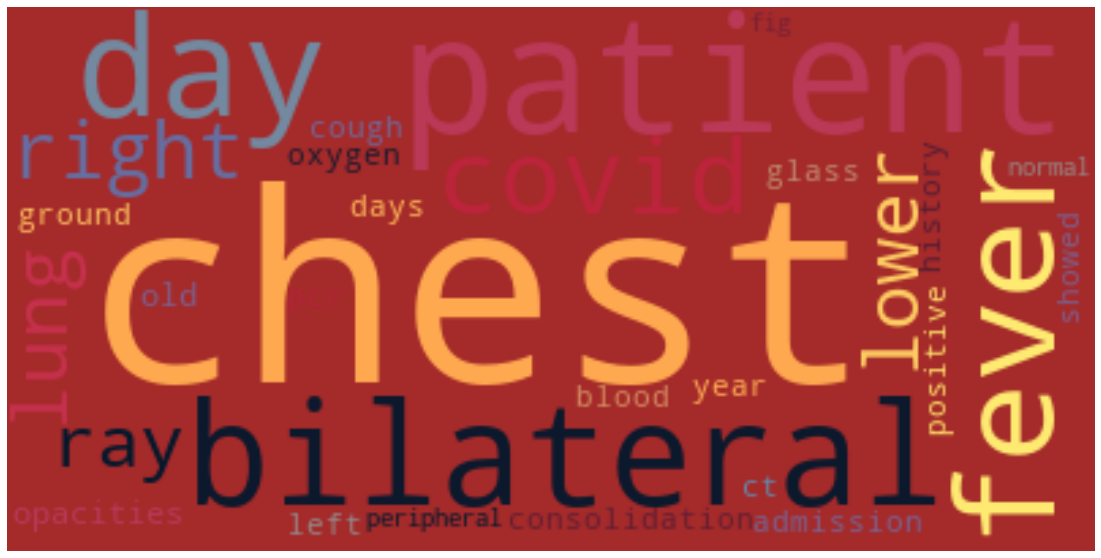

In [39]:
# visualizing cleaned data
hero.visualization.wordcloud(pd.Series(cleaned_data), max_words=30,background_color="brown")

In [40]:
def stemmingNotes(data):
    """
    Parm: list(str)
    Returns: list(str) after stemming
    """
    cleaned_notes = []
    porter = PorterStemmer() # Using the default nltk Porter Stemmer for text normalization
    for text in data:
        token_words = word_tokenize(text)
        stem_sentence = []
        for word in token_words:
            stem_sentence.append(porter.stem(word))
        cleaned_notes.append(" ".join(stem_sentence))
    return cleaned_notes


In [41]:
final_notes = stemmingNotes(cleaned_data)

In [43]:
data["clinical_notes"][:] = final_notes[:]

In [80]:
data["RT_PCR_positive"][936]

'Unclear'

# Data preparation

In [44]:
class CovidResult:
  POSITIVE = "POSITIVE"
  UNCLEAR_ = "UNCLEAR_"

class Notes:
  def __init__(self, clinical_notes, rt_pcr):
    self.clinical_notes = clinical_notes
    self.rt_pcr = rt_pcr
    self.result = self.get_result()

  def get_result(self):
    if self.rt_pcr == "Y":
      return CovidResult.POSITIVE
    elif self.rt_pcr == "Unclear":
      return CovidResult.UNCLEAR_

In [46]:
allData = []
for i in range(len(data)):
  allData.append(Notes(data["clinical_notes"].iloc[i], data["RT_PCR_positive"].iloc[i]))
allData[15].result # checking


'POSITIVE'

In [47]:
training, test = train_test_split(allData, test_size = 0.3, random_state=42)

In [48]:
train_x = [x.clinical_notes for x in training]
train_y = [x.result for x in training]
test_x = [x.clinical_notes for x in test]
test_y = [x.result for x in test]

In [49]:
vectorizer = CountVectorizer()
train_x_vector = vectorizer.fit_transform(train_x)
test_x_vector = vectorizer.transform(test_x)

# Models for classification
* testing different models

In [54]:
# Linear svm
clf_svm = svm.SVC(kernel="linear")
clf_svm.fit(train_x_vector, train_y)

# Decision tree
cls_dec = DecisionTreeClassifier()
cls_dec.fit(train_x_vector, train_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [55]:
# testing two single for both models
print(clf_svm.predict(test_x_vector[0]))
print(cls_dec.predict(test_x_vector[0]))


['POSITIVE']
['POSITIVE']


## Evaluation
* see mean accuracy score
* see f1_score
* tuning our models
* chose the best model

In [56]:
# mean accuracy
print(clf_svm.score(test_x_vector, test_y))
print(cls_dec.score(test_x_vector, test_y))


0.7798165137614679
0.8807339449541285


In [57]:
# f1_score
f1_score(test_y, clf_svm.predict(test_x_vector), average=None, labels=[CovidResult.POSITIVE, CovidResult.UNCLEAR_])
f1_score(test_y, cls_dec.predict(test_x_vector), average=None, labels=[CovidResult.POSITIVE, CovidResult.UNCLEAR_])

array([0.92121212, 0.75471698])

In [58]:
print(train_y.count(CovidResult.UNCLEAR_))
print(train_y.count(CovidResult.POSITIVE))

63
190


## Tuning models

In [82]:
# tuning first model
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf_Svm = GridSearchCV(svc, parameters)
clf_Svm.fit(train_x_vector, train_y)
print(clf_Svm.best_score_, clf_Svm.best_params_)

# tuning second model
from sklearn.model_selection import GridSearchCV
from sklearn import tree
parameters = {'max_depth':range(3,20)}
clf_dec = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf_dec.fit(train_x_vector, train_y)
tree_model = clf_dec.best_estimator_
print(clf_dec.best_score_, clf_dec.best_params_) 



0.8338039215686275 {'C': 10, 'kernel': 'rbf'}
0.8022745098039217 {'max_depth': 14}


## Confusion Matrix

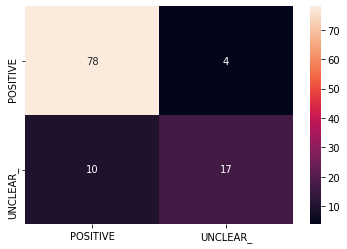

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf_Svm.predict(test_x_vector)

labels = [CovidResult.POSITIVE, CovidResult.UNCLEAR_]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

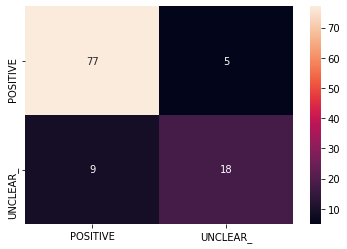

In [65]:
# for 
y_pred = clf_dec.predict(test_x_vector)

labels = [CovidResult.POSITIVE, CovidResult.UNCLEAR_]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

In [118]:
# tesing one comment from a patient/ here the problem is, we have very few data, i.e the model is trained only on a few data
# lets test the model with true value of unclear
for i in range(3):
  x = np.random.randint(1,100)
  test_set = data["clinical_notes"][x]
  new_test = vectorizer.transform([test_set])
  print("True values from original dataset: " + data["RT_PCR_positive"][x] + " and the predicted: ", clf_Svm.predict(new_test))

True values from original dataset: Y and the predicted:  ['POSITIVE']
True values from original dataset: Unclear and the predicted:  ['UNCLEAR_']
True values from original dataset: Y and the predicted:  ['POSITIVE']


# Saving best model

In [62]:
# To save the model
#with open("name of path", "wb") as f:
#  pickle.dump(clf, f)

# To load the model
#with open("name of path", "wb") as f:
#  loadclf = pickle.load(clf, f)

#loadclf.predict(test_x_vector[0])

<h1><center><u>PHASE-2 and PHASE-3</u></center></h1>

In [16]:
data = pd.read_csv("/content/gdrive/MyDrive/DATA/metadata.csv")

In [17]:
data.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [18]:
class dataProcessing:
    
    def imageProcessing(self, train_location, test_location):
                
        train_datagen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
        test_datagen = ImageDataGenerator(rescale = 1./255)
        
        training_set = train_datagen.flow_from_directory(train_location,
                                                        target_size = (64, 64),
                                                        batch_size = 32,
                                                        class_mode = "binary")
        test_set = test_datagen.flow_from_directory(test_location,
                                           target_size = (64, 64),
                                           batch_size = 32,
                                           class_mode = "binary")
        return training_set, test_set  
    
    def dataCleanerForAnn(self, data): # this is only for our case
        df1 = data[["sex", "age", "went_icu", "temperature", "RT_PCR_positive"]]
        df1["sex"] = pd.get_dummies(df1["sex"], drop_first=True)
        df1["went_icu"] = pd.get_dummies(df1["went_icu"], drop_first=True)
        df1["RT_PCR_positive"] = pd.get_dummies(df1["RT_PCR_positive"], drop_first=True)

        df1["temperature"].fillna(df1["temperature"].mean(), inplace=True)
        df1["age"].fillna(df1["age"].mean(), inplace=True)
        return df1
    
    def splittingAndScaling(self, datapath):
        data = pd.read_csv(datapath)
        arrangedData  = self.dataCleanerForAnn(data)
        X = arrangedData.iloc[:, :-1].values
        y = arrangedData.iloc[: ,-1].values 
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        return X_train, X_test, y_train, y_test

In [19]:
class buildModel:
    
    def annModel(self, X_train, y_train):
        ann = tf.keras.models.Sequential()
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        ann.fit(X_train, y_train, batch_size = 32, epochs = 10)
        return ann
        
    def cnnModel(self, train, test):
        cnn = tf.keras.models.Sequential()
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Flatten())
        cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
        cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        cnn.fit(x = train, validation_data = test, epochs = 2)
        
        return cnn
    

In [20]:
def predicter(im):
    # call the saved model as a pickle   
    # ????
    train_location = "/content/gdrive/MyDrive/DATA/train"
    test_location = "/content/gdrive/MyDrive/DATA/test"
    DP = dataProcessing()
    bM = buildModel()
    train, test  = DP.imageProcessing(train_location, test_location)
    cnn = bM.cnnModel(train, test)
    
    
    test_image = image.load_img(im, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image) # cnn == the saved model
    
    if result[0][0] <= 0.1: # test for the probabilites is less than 10%
        prediction = 'NON-COVID'
    else:
        prediction = 'COVID-19'

    #print(prediction)
    return prediction
    
    

In [21]:
def testSingleImagePrediction(): # here the point is to test random picked images(one from each)
    # from line 3 to line 9 we see as saved model
    
    
    ## Here I want to test when the model is saved
    # both these images are in the test-set(i.e one random from covid and one from noncovid)
    
    test_covid = "/content/gdrive/MyDrive/DATA/test/covid/"
    test_non_covid = "/content/gdrive/MyDrive/DATA/test/non/"

    Covid_in_test = [i for i in os.listdir(test_covid)]
    nonCovid_in_test = [i for i in os.listdir(test_non_covid)]
    
    test1 = test_covid + random.choice(Covid_in_test)
    test2 = test_non_covid + random.choice(nonCovid_in_test)
    
    imageCovid = mpimg.imread(test1)
    plt.imshow(imageCovid)
    plt.title("True image-1 of Covid")
    plt.show()
    
    imageNonCovid = mpimg.imread(test2)
    plt.imshow(imageNonCovid)
    plt.title("True image:2 of Non-Covid")
    plt.show()
    
    return ("Result of image-1 is: %s. Result of image-2 is: %s." %(predicter(test1), predicter(test2)) )
    

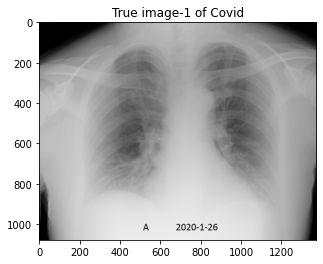

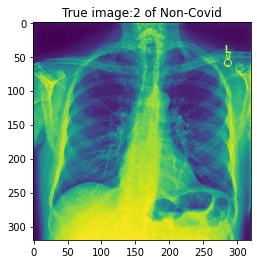

Found 2086 images belonging to 2 classes.
Found 2873 images belonging to 2 classes.
Epoch 1/2
66/66 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.8991

KeyboardInterrupt: ignored

In [22]:
testSingleImagePrediction()

In [ ]:
def saveModel():
    # datapath
    train_location = "/content/gdrive/MyDrive/DATA/train" 
    test_location = "/content/gdrive/MyDrive/DATA/test"
    metaData = "/content/gdrive/MyDrive/DATA/metadata.csv"
    
    #classes
    DP = dataProcessing()
    models = buildModel()
    
    train, test  = DP.imageProcessing(train_location, test_location)
    X_train, X_test, y_train, y_test = DP.splittingAndScaling(metaData)
    
    print("CNN starts: \n")
    cnnModel = models.cnnModel(train, test)
    print("ANN starts: \n")
    annModel = models.annModel(X_train, y_train)
    
    #cnnModel.save("CNN.h5")
    #annModel.save("ANN.h5")

In [24]:
def NoneReturner():
    print("default")

In [25]:
if __name__ == "__main__":
    #prediction()
    #saveModel()
    NoneReturner()


default
